## Рекомендательная система с фильтрацией на основе содержимого (content-based filtering)

# Импорт библиотек



In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from functools import lru_cache
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('wordnet') # проводит лемматизацию
nltk.download('punkt')  # Для токенизации
nltk.download('stopwords')  # Для списка стоп-слов

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
pd.set_option('max_colwidth', 200)

# Загрузка датасета

In [7]:
data = pd.read_csv('/content/netflix_titles.csv', delimiter=',', on_bad_lines='skip',  engine='python')

Датасет состоит из 12 атрибутов и 8658 строк, где каждый атрибут описывает различные характеристики фильмов и сериалов:

1.	show_id: Уникальный идентификатор для каждого элемента.

3.	type: Тип контента — фильм ("Movie") или телешоу ("TV Show").

5.	title: Название фильма или шоу.

7.	director: Имя режиссёра (может содержать пропуски).

9.	cast: Список актёров (может содержать пропуски).

11.	country: Страна происхождения (может содержать пропуски).

13.	date_added: Дата добавления контента на платформу (может содержать пропуски).

15.	release_year: Год выпуска.

17.	rating: Возрастной рейтинг.

18.	duration: Продолжительность (для фильмов) или количество сезонов (для шоу).

20.	listed_in: Жанры или категории, к которым принадлежит контент.

22.	description: Краткое описание содержания.




In [8]:
data.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Ma...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Action & Adventure","To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war."
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down among the incarcerated women at the Orleans Justice Center in New Orleans on this gritty reality series."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam Khan, Ahsaas Channa, Revathi Pillai, Urvi Singh, Arun Kumar",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV Comedies","In a city of coaching centers known to train India’s finest collegiate minds, an earnest but unexceptional student and his friends navigate campus life."


In [9]:
# DataFrame с числом пропусков и названиями признаков в индексе
null_counts_df = pd.DataFrame(data.isnull().sum(), columns=['Число пропусков'])

# Вывод результата
null_counts_df.sort_values(ascending=False, by='Число пропусков')


,Число пропусков
director,2634
country,831
cast,825
date_added,10
rating,4
duration,3
show_id,0
type,0
title,0
release_year,0


In [10]:
data['type'].unique()

array(['Movie', 'TV Show'], dtype=object)

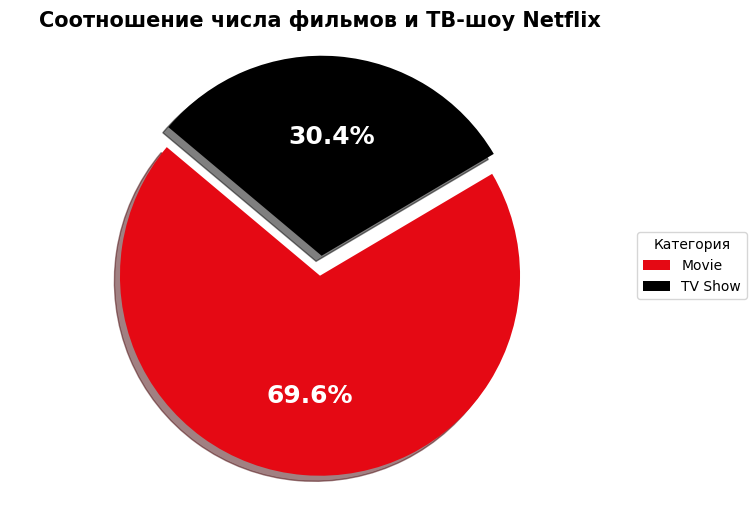

In [11]:
type_counts = data['type'].value_counts()

type_percentages = (type_counts / len(data)) * 100


plt.figure(figsize=(8, 6))
colors = ['#E50914', '#000000']
explode = (0.1, 0)

wedges, texts, autotexts = plt.pie(
    type_percentages,
    labels=type_counts.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    explode=explode,
    shadow=True,
    textprops=dict(color="white", weight="bold", fontsize=18)
)

for text in texts:
    text.set_color('white')
    text.set_fontweight('bold')


plt.legend(wedges, type_counts.index, title="Категория", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Соотношение числа фильмов и ТВ-шоу Netflix', fontweight='bold', fontsize=15)
plt.axis('equal')

plt.show()

<ipython-input-12-28efbce82109>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = country_10.index,y=country_10.values, palette='flare')


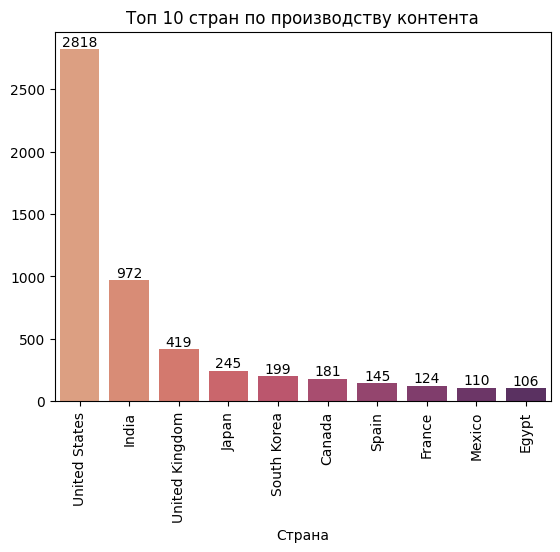

In [12]:
country_10 = data["country"].value_counts().head(10)
ax = sns.barplot(x = country_10.index,y=country_10.values, palette='flare')
plt.title('Топ 10 стран по производству контента')
plt.xticks(rotation=90)
plt.xlabel('Страна')

for i in ax.containers:
    ax.bar_label(i,)
plt.show()

Количество уникальных категорий фильмов

In [13]:
unique_categories=data['listed_in'].unique()
len(unique_categories)

514

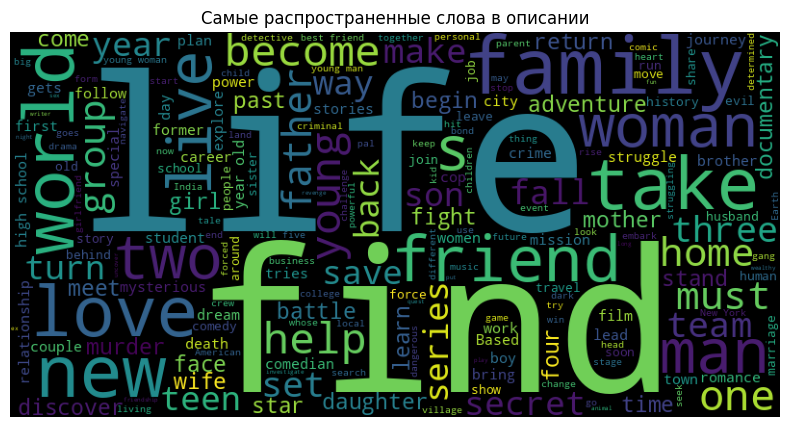

In [14]:
from wordcloud import WordCloud

text = ' '.join(data['description'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Самые распространенные слова в описании')
plt.show()

Распределение по году выпуска фильмов

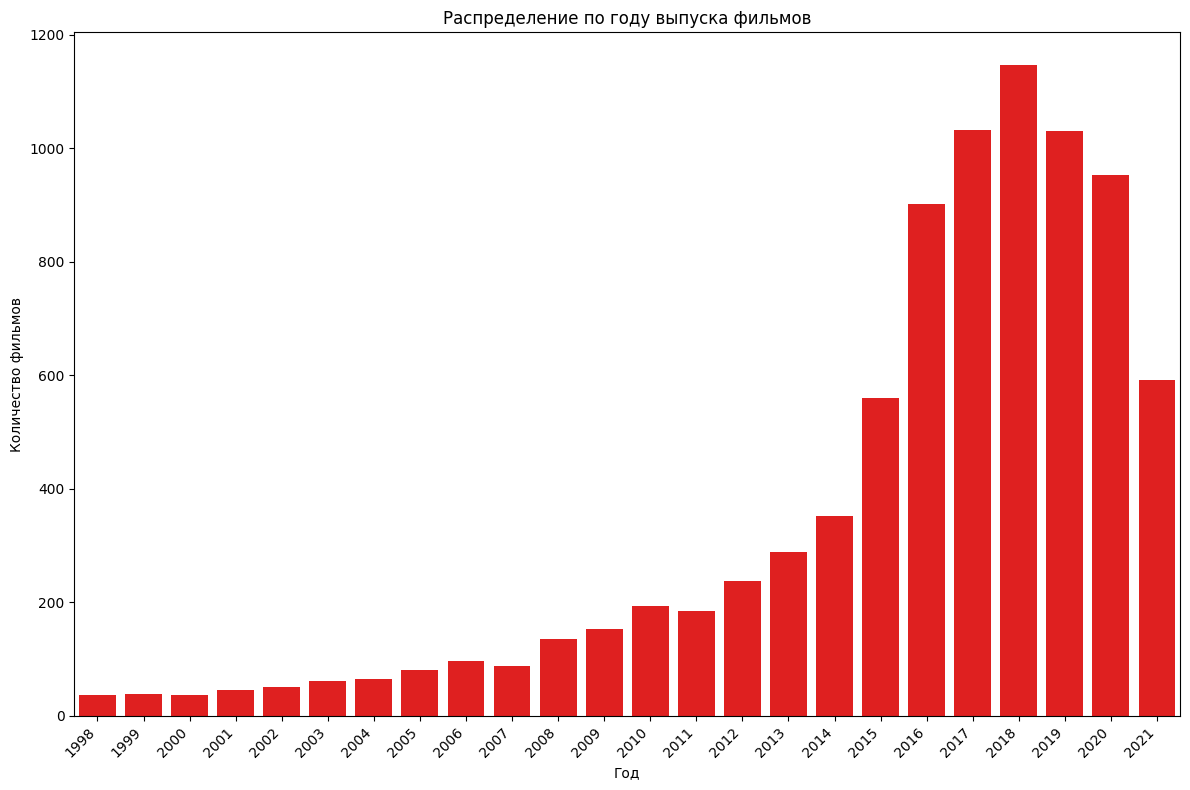

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Предположим, что у вас есть DataFrame 'data' и вычислили value_counts:
year_counts = data['release_year'].value_counts().sort_index() # Сортируем по году

# Создаем DataFrame для построения гистограммы
year_df = pd.DataFrame({'Year': year_counts.index, 'Count': year_counts.values})

plt.figure(figsize=(12, 8))
sns.barplot(x='Year', y='Count', data=year_df[50:], color='red') # Используем barplot для точного отображения количества
plt.title('Распределение по году выпуска фильмов')
plt.xlabel('Год')
plt.ylabel('Количество фильмов')
plt.xticks(rotation=45, ha='right') # Поворачиваем подписи на оси x для лучшей читаемости
plt.tight_layout() # Улучшаем расположение элементов графика
plt.show()


In [16]:
data['release_year'].value_counts()

,count
release_year,
2018,1147
2017,1032
2019,1030
2020,953
2016,902
...,...
1959,1
1925,1
1961,1


# Система рекомендаций на основе описания сюжета



В датасете достаточно разнообразная лексика — уникальные слова суммарно составляют 18740 уникальных слов.

Косинусное сходство — это мера сходства между двумя ненулевыми векторами, широко применяемая во многих приложениях машинного обучения и анализа данных

Формула для расчёта косинусного сходства между двумя векторами имеет вид: Cos (A, B) = A . B / ||A|| × ||B||,

где A . B — произведение векторов x и y,

A⋅B — это скалярное произведение (dot product) векторов

∥A∥ и ∥B∥ — это евклидовы нормы (длины) векторов A и B, которые вычисляются как квадратный корень из внутреннего произведения вектора на самого себя


<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/2a8c50526e2cc7aa837477be87eff1ea703f9dec'>

измеряет степень схожести между двумя текстовыми векторами и показывает, насколько похожи два описания фильмов или шоу. Значение косинусного сходства варьируется от 0 до 1:

•	1 означает полное совпадение векторов, т.е. оба описания идентичны.

•	0 означает отсутствие совпадения, т.е. описания совершенно разные.


# Content-based рекомендации по описанию

In [17]:
# Предварительная обработка текста
def preprocessing(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text.lower()) # Токенизация
    result = [lemmatizer.lemmatize(word) for word in tokens
              if word.isalpha() and word not in stop_words] #Лемматизация и удаление стоп-слов
    return ' '.join(result)
# Кэшируемые данные
@lru_cache(maxsize=100)
def create_matrix(corpus, type='tf-idf'):
  if type == 'CountVectorizer':
        vectorizer = CountVectorizer()
  else:
    vectorizer = TfidfVectorizer()
  matrix = vectorizer.fit_transform(corpus)
  return matrix


# Рекомендации на основе описания
def get_recommendations_by_description(titles, df,  type, n=5):
    if not titles:
        return "Список названий фильмов пуст."

    # Предобработка текстов
    df['feature'] = df['description'].apply(preprocessing)

    # Создание матрицы
    matrix = create_matrix(tuple(df['feature']), type)  # Передаём список как tuple

    # Индексы
    indexes = pd.Series(df.index, index=df['title'])
    # Проверяем наличие фильмов
    input = [indexes[title] for title in titles if title in indexes]
    if not input:
        return "Ни один из указанных фильмов не найден в базе данных."

    # Средний вектор для фильмов
    input_vector = np.mean(matrix[input].toarray(), axis=0, keepdims=True)

    # Косинусное сходство
    cos = cosine_similarity(input_vector, matrix).flatten()

    # Сортировка и рекомендации
    result = cos.argsort()[::-1][len(titles):n + len(titles)]
    recommendations = df.iloc[result][['title', 'cast', 'director', 'listed_in', 'description']]

    return recommendations


In [18]:
# Пример использования
#Векторизатор - TF-IDF
titles_to_search = ["Van Helsing", 'Twilight']
get_recommendations_by_description(  titles_to_search, data, type = 'TF-IDF')

,title,cast,director,listed_in,description
450,The Twilight Saga: New Moon,"Kristen Stewart, Robert Pattinson, Taylor Lautner, Ashley Greene, Rachelle Lefevre, Billy Burke, Michael Sheen, Dakota Fanning, Peter Facinelli, Elizabeth Reaser, Jackson Rathbone, Kellan Lutz, Ni...",Chris Weitz,"Dramas, Romantic Movies","Still reeling from the departure of vampire Edward Cullen, a heartbroken Bella Swan finds comfort in her friendship with werewolf Jacob Black."
449,The Twilight Saga: Eclipse,"Kristen Stewart, Robert Pattinson, Taylor Lautner, Bryce Dallas Howard, Billy Burke, Dakota Fanning, Peter Facinelli, Elizabeth Reaser, Jackson Rathbone, Kellan Lutz, Ashley Greene, Nikki Reed",David Slade,"Dramas, Romantic Movies","With a bloodthirsty enemy on a quest for revenge, Bella must reconcile her love for vampire Edward and her growing feelings for werewolf Jacob."
2744,The Little Vampire,"Matthew Marsh, Rasmus Hardiker, Miriam Margolyes, Tim Pigott-Smith, Alice Krige, Amy Saville, Joseph Kloska, Diane Wilson, Phoebe Givron-Taylor, Jim Carter, Sven De Ridder","Richard Claus, Karsten Kiilerich",Children & Family Movies,An American kid obsessed with the undead befriends and offers to help a young vampire whose family is being targeted by a merciless vampire hunter.
2797,Vampires,"Oulaya Amamra, Suzanne Clément, Kate Moran, Mounir Amamra, Aliocha Schneider, Juliette Cardinski, Pierre Lottin, Dylan Robert, Bilel Chegrani, Antonia Buresi, Marilu Marini, Ayumi Roux",NaN,"International TV Shows, TV Dramas, TV Horror","A Paris teen who's half human, half vampire grapples with her emerging powers and family turmoil as she's pursued by a secret vampire community."
8268,The Darkest Dawn,NaN,NaN,"Action & Adventure, Independent Movies, International Movies",An aspiring filmmaker records the chaos of an alien invasion while struggling to stay alive with her sister and a bickering band of survivors.


In [19]:
# Пример использования
#Векторизатор - CountVectorizer
titles_to_search = ["Van Helsing", 'Twilight']
get_recommendations_by_description(titles_to_search, data, type = 'CountVectorizer')

,title,cast,director,listed_in,description
450,The Twilight Saga: New Moon,"Kristen Stewart, Robert Pattinson, Taylor Lautner, Ashley Greene, Rachelle Lefevre, Billy Burke, Michael Sheen, Dakota Fanning, Peter Facinelli, Elizabeth Reaser, Jackson Rathbone, Kellan Lutz, Ni...",Chris Weitz,"Dramas, Romantic Movies","Still reeling from the departure of vampire Edward Cullen, a heartbroken Bella Swan finds comfort in her friendship with werewolf Jacob Black."
8268,The Darkest Dawn,NaN,NaN,"Action & Adventure, Independent Movies, International Movies",An aspiring filmmaker records the chaos of an alien invasion while struggling to stay alive with her sister and a bickering band of survivors.
449,The Twilight Saga: Eclipse,"Kristen Stewart, Robert Pattinson, Taylor Lautner, Bryce Dallas Howard, Billy Burke, Dakota Fanning, Peter Facinelli, Elizabeth Reaser, Jackson Rathbone, Kellan Lutz, Ashley Greene, Nikki Reed",David Slade,"Dramas, Romantic Movies","With a bloodthirsty enemy on a quest for revenge, Bella must reconcile her love for vampire Edward and her growing feelings for werewolf Jacob."
4996,Bullet Head,"Adrien Brody, John Malkovich, Rory Culkin, Antonio Banderas, Ori Pfeffer, Alexandra Dinu, Owen Davis, Deyan Petrov","Paul Solet, Rick Benattar","International Movies, Thrillers","After a daring heist, three fugitives lock themselves in a warehouse hoping to evade the police, but find a worse threat as they fight to stay alive."
2847,Freaks,"Emile Hirsch, Bruce Dern, Lexy Kolker, Grace Park, Amanda Crew, Aleks Paunovic, Michelle Harrison","Adam B. Stein, Zach Lipovsky","Independent Movies, Sci-Fi & Fantasy, Thrillers","Hidden away by her eccentric father, a mysterious young girl uncovers frightening truths when she starts to make contact with the outside world."


In [20]:
# Пример использования
#Векторизатор - TF-IDF
get_recommendations_by_description(['Charlie and the Chocolate Factory'], data, type = 'TF-IDF')

,title,cast,director,listed_in,description
8745,Willy Wonka & the Chocolate Factory,"Gene Wilder, Jack Albertson, Peter Ostrum, Roy Kinnear, Julie Dawn Cole, Leonard Stone, Denise Nickerson, Dodo Denney, Paris Themmen, Ursula Reit",Mel Stuart,"Children & Family Movies, Classic Movies, Comedies",Zany Willy Wonka causes a stir when he announces that golden tickets hidden inside his candy bars will admit holders into his secret confectionary.
1773,Zumbo's Just Desserts,"Adriano Zumbo, Rachel Khoo",NaN,"International TV Shows, Reality TV","Dessert wizard Adriano Zumbo looks for the next “Willy Wonka” in this tense competition that finds skilled amateurs competing for a $100,000 prize."
2047,Spirit Riding Free: Riding Academy,"Amber Frank, Bailey Gambertoglio, Sydney Park, Darcy Rose Byrnes, Rhys Darby",NaN,Kids' TV,A new chapter begins for Lucky and her friends as they leave Miradero behind to live and learn at the prestigious Palomino Bluffs Riding Academy.
8008,Shorgul,"Ashutosh Rana, Jimmy Shergill, Suha Gezen, Sanjay Suri, Narendra Jha, Hiten Tejwani, Eijaz Khan, Aniruddha Dave","Jitendra Tiwari, Pranav Singh","Dramas, International Movies",A Hindu boy's feelings for a Muslim girl expose the tensions between their two communities and open the door to chaos and violence.
3071,Reply 1988,"Lee Hye-ri, Park Bo-gum, Ryu Jun-yeol, Ko Kyoung-pyo, Lee Dong-hwi, Ryu Hye-young, Sung Dong-il, Lee Il-hwa",NaN,"International TV Shows, Korean TV Shows, Romantic TV Shows",Take a nostalgic trip back to the late 1980s through the lives of five families and their five teenage kids living in a small neighborhood in Seoul.


In [21]:
# Пример использования
#Векторизатор - CountVectorizer
get_recommendations_by_description(['Charlie and the Chocolate Factory'], data, type = 'CountVectorizer')

,title,cast,director,listed_in,description
8745,Willy Wonka & the Chocolate Factory,"Gene Wilder, Jack Albertson, Peter Ostrum, Roy Kinnear, Julie Dawn Cole, Leonard Stone, Denise Nickerson, Dodo Denney, Paris Themmen, Ursula Reit",Mel Stuart,"Children & Family Movies, Classic Movies, Comedies",Zany Willy Wonka causes a stir when he announces that golden tickets hidden inside his candy bars will admit holders into his secret confectionary.
2047,Spirit Riding Free: Riding Academy,"Amber Frank, Bailey Gambertoglio, Sydney Park, Darcy Rose Byrnes, Rhys Darby",NaN,Kids' TV,A new chapter begins for Lucky and her friends as they leave Miradero behind to live and learn at the prestigious Palomino Bluffs Riding Academy.
3415,THE UNLISTED,"Vrund Rao, Ved Rao, Abigail Adriano, Miah Madden, Jean Hinchliffe, Nya Cofie, Saba Zaidi Abdi, Nicholas Brown, Virginie Laverdure, Avishma Lohith, Zenia Starr, Suzi Dougherty, Aria Ferris, Danny K...",NaN,"Kids' TV, TV Thrillers","When they learn of a secret plot to track and control kids, identical twins Dru and Kal team up with a band of runaway rebels to take back their world."
3071,Reply 1988,"Lee Hye-ri, Park Bo-gum, Ryu Jun-yeol, Ko Kyoung-pyo, Lee Dong-hwi, Ryu Hye-young, Sung Dong-il, Lee Il-hwa",NaN,"International TV Shows, Korean TV Shows, Romantic TV Shows",Take a nostalgic trip back to the late 1980s through the lives of five families and their five teenage kids living in a small neighborhood in Seoul.
7654,Once In A Lifetime Sessions with Moby,"Moby, Alex Cohen",Matt Askem,"Documentaries, Music & Musicals","Through performances and interviews, musician Moby opens up about his unusual childhood, his heroes and the stories behind his songs."


Наиболее схожий фильм из предоставленного списка  - "Zumbo's Just Desserts"
напоминает "Willy Wonka and the Chocolate Factory" по концепции. Описание указывает на то, что герой Адриано Зумбо ищет следующего "Вилли Вонку" среди участников конкурса, что явно отсылает к персонажу.
Остальные фильмы и шоу не кажутся напрямую связанными с темой "Willy Wonka and the Chocolate Factory", так как они охватывают совершенно разные сюжеты, такие как детективные истории и академии верховой езды,

Из этого можно сделать вывод что модель работает удовлетворительно. Точность можно улучшить, добавив дополнительные признаки

# Content-based рекомендации по нескольким признакам


###### Для улучшения рекомендаций мы можем комбинировать несколько признаков, чтобы учесть не только описание, но и такие характеристики, как актёры, режиссёр и жанры. Этот подход предоставляет более полное представление о фильме, повышая точность рекомендации, особенно если пользователь интересуется конкретными аспектами, такими как актерский состав или жанр.

Для определения схожих объектов будут использованы следующие атрибуты:
* Заголовок(Title)
* Актеры (Cast)
* Режиcсер (Director)
* Год выхода (Listed in)
* Сюжет (Description)

In [22]:
# Рекомендации на основе объединённых признаков
def get_recommendations_by_features(titles, df, type, n=5):
    if not titles:
        return "Список названий фильмов пуст."

    # Обработка пропущенных значений и объединение признаков
    df['feature'] = (
        df['title'].fillna('') + ' ' +           # Заголовок
        df['cast'].fillna('') + ' ' +            # Актёры
        df['director'].fillna('') + ' ' +        # Режиссёр
        df['listed_in'].fillna('') + ' ' +       # Жанр (категория)
        df['description'].fillna('')+            # Описание
        df['country'].fillna('') + ' '          # Страна
    ).apply(preprocessing)  # предварительная обработка

    # Матрица частоты слов
    matrix = create_matrix(tuple(df['feature']), type)

    # Построение индекса фильмов
    indexes = pd.Series(df.index, index=df['title'])

    # Проверяем наличие фильмов
    input = [indexes[title] for title in titles if title in indexes]
    if not input:
        return "Ни один из указанных фильмов не найден в базе данных."

    # Средний вектор для фильмов
    input_vector = np.mean(matrix[input].toarray(), axis=0, keepdims=True)

    # Косинусное сходство
    simularity = cosine_similarity(input_vector, matrix).flatten()

    # Сортировка и рекомендации
    result = simularity.argsort()[::-1][len(titles):n + len(titles)]
    recommendations = df.iloc[result][['title', 'cast', 'director', 'listed_in', 'description']]

    return recommendations


In [23]:
# Пример использования
#Векторизатор - TF-IDF
titles_to_search = ["Van Helsing", "Twilight"]
get_recommendations_by_features(titles_to_search, data, type = 'TF-IDF')

,title,cast,director,listed_in,description
447,The Twilight Saga: Breaking Dawn: Part 1,"Kristen Stewart, Robert Pattinson, Taylor Lautner, Billy Burke, Peter Facinelli, Elizabeth Reaser, Kellan Lutz, Nikki Reed, Jackson Rathbone, Ashley Greene",Bill Condon,"Dramas, Romantic Movies","After a dream wedding, Bella and Edward enter a new nightmare when a shocking development forces life-or-death decisions."
448,The Twilight Saga: Breaking Dawn: Part 2,"Kristen Stewart, Robert Pattinson, Taylor Lautner, Peter Facinelli, Elizabeth Reaser, Ashley Greene, Jackson Rathbone, Kellan Lutz, Nikki Reed, Billy Burke",Bill Condon,"Dramas, Romantic Movies","In the epic series' final chapter, Bella and Edward's newborn daughter forces the couple into a life-altering confrontation with the Volturi."
449,The Twilight Saga: Eclipse,"Kristen Stewart, Robert Pattinson, Taylor Lautner, Bryce Dallas Howard, Billy Burke, Dakota Fanning, Peter Facinelli, Elizabeth Reaser, Jackson Rathbone, Kellan Lutz, Ashley Greene, Nikki Reed",David Slade,"Dramas, Romantic Movies","With a bloodthirsty enemy on a quest for revenge, Bella must reconcile her love for vampire Edward and her growing feelings for werewolf Jacob."
450,The Twilight Saga: New Moon,"Kristen Stewart, Robert Pattinson, Taylor Lautner, Ashley Greene, Rachelle Lefevre, Billy Burke, Michael Sheen, Dakota Fanning, Peter Facinelli, Elizabeth Reaser, Jackson Rathbone, Kellan Lutz, Ni...",Chris Weitz,"Dramas, Romantic Movies","Still reeling from the departure of vampire Edward Cullen, a heartbroken Bella Swan finds comfort in her friendship with werewolf Jacob Black."
943,Never Back Down,"Sean Faris, Amber Heard, Cam Gigandet, Evan Peters, Leslie Hope, Djimon Hounsou, Wyatt Smith, Affion Crockett, Neil Brown Jr., Lauren Leech, Tilky Jones, Steven Crowley, Tom Nowicki",Jeff Wadlow,"Action & Adventure, Dramas, Sports Movies","When a quick-tempered teen moves to a new town and faces the challenges of attending a new high school, he seeks solace in an underground fight club."


In [24]:
# Пример использования
#Векторизатор - CountVectorizer
titles_to_search = ["Van Helsing", "Twilight"]
get_recommendations_by_features(titles_to_search, data, type = 'CountVectorizer')

,title,cast,director,listed_in,description
447,The Twilight Saga: Breaking Dawn: Part 1,"Kristen Stewart, Robert Pattinson, Taylor Lautner, Billy Burke, Peter Facinelli, Elizabeth Reaser, Kellan Lutz, Nikki Reed, Jackson Rathbone, Ashley Greene",Bill Condon,"Dramas, Romantic Movies","After a dream wedding, Bella and Edward enter a new nightmare when a shocking development forces life-or-death decisions."
449,The Twilight Saga: Eclipse,"Kristen Stewart, Robert Pattinson, Taylor Lautner, Bryce Dallas Howard, Billy Burke, Dakota Fanning, Peter Facinelli, Elizabeth Reaser, Jackson Rathbone, Kellan Lutz, Ashley Greene, Nikki Reed",David Slade,"Dramas, Romantic Movies","With a bloodthirsty enemy on a quest for revenge, Bella must reconcile her love for vampire Edward and her growing feelings for werewolf Jacob."
448,The Twilight Saga: Breaking Dawn: Part 2,"Kristen Stewart, Robert Pattinson, Taylor Lautner, Peter Facinelli, Elizabeth Reaser, Ashley Greene, Jackson Rathbone, Kellan Lutz, Nikki Reed, Billy Burke",Bill Condon,"Dramas, Romantic Movies","In the epic series' final chapter, Bella and Edward's newborn daughter forces the couple into a life-altering confrontation with the Volturi."
450,The Twilight Saga: New Moon,"Kristen Stewart, Robert Pattinson, Taylor Lautner, Ashley Greene, Rachelle Lefevre, Billy Burke, Michael Sheen, Dakota Fanning, Peter Facinelli, Elizabeth Reaser, Jackson Rathbone, Kellan Lutz, Ni...",Chris Weitz,"Dramas, Romantic Movies","Still reeling from the departure of vampire Edward Cullen, a heartbroken Bella Swan finds comfort in her friendship with werewolf Jacob Black."
3725,Shooter,"Ryan Phillippe, Omar Epps, David Marciano, Cynthia Addai-Robinson, Shantel VanSanten, Tom Sizemore",NaN,"Crime TV Shows, TV Action & Adventure, TV Dramas","A highly decorated ex-Marine sniper returns to action to foil an assassination plot targeting the president, but soon finds himself framed for murder."


In [25]:
# Пример использования
#Векторизатор - TF-IDF
get_recommendations_by_features(['Charlie and the Chocolate Factory'], data, type = 'TF-IDF')

,title,cast,director,listed_in,description
8745,Willy Wonka & the Chocolate Factory,"Gene Wilder, Jack Albertson, Peter Ostrum, Roy Kinnear, Julie Dawn Cole, Leonard Stone, Denise Nickerson, Dodo Denney, Paris Themmen, Ursula Reit",Mel Stuart,"Children & Family Movies, Classic Movies, Comedies",Zany Willy Wonka causes a stir when he announces that golden tickets hidden inside his candy bars will admit holders into his secret confectionary.
8138,Sweeney Todd: The Demon Barber of Fleet Street,"Johnny Depp, Helena Bonham Carter, Alan Rickman, Timothy Spall, Sacha Baron Cohen, Jamie Campbell Bower, Laura Michelle Kelly, Jayne Wisener, Ed Sanders",Tim Burton,"Dramas, Horror Movies, Music & Musicals","After being falsely imprisoned, a vengeful murderer covers his tracks by enlisting the help of a baker whose meat pies become the toast of London."
3567,American Factory,NaN,"Steven Bognar, Julia Reichert",Documentaries,"In this documentary, hopes soar when a Chinese company reopens a shuttered factory in Ohio. But a culture clash threatens to shatter an American dream."
7275,LeapFrog: Letter Factory,"Joey Camen, Marie Danielle, Mark Cacciatore, Dave Fennoy, Debi Derryberry",Roy Allen Smith,Children & Family Movies,"In this entertaining installment of the wildly popular early-learning series, Professor Quigley, Leap, Lily and Tad arrive at the magical Letter Factory, where jumbles of sounds are miraculously s..."
5570,Howards End,"Anthony Hopkins, Vanessa Redgrave, Helena Bonham Carter, Emma Thompson, James Wilby, Samuel West, Jemma Redgrave, Joseph Bennett, Nicola Duffett, Susie Lindeman",James Ivory,"Classic Movies, Dramas, Independent Movies","When a husband, acting in his family's ""best interest,"" does not accept his wife's deathbed wish, providence dictates that he pay for his duplicity."


In [ ]:
# Пример использования
#Векторизатор - CountVectorizer
get_recommendations_by_features(['Charlie and the Chocolate Factory'], data, type = 'CountVectorizer')

,title,cast,director,listed_in,description
8745,Willy Wonka & the Chocolate Factory,"Gene Wilder, Jack Albertson, Peter Ostrum, Roy Kinnear, Julie Dawn Cole, Leonard Stone, Denise Nickerson, Dodo Denney, Paris Themmen, Ursula Reit",Mel Stuart,"Children & Family Movies, Classic Movies, Comedies",Zany Willy Wonka causes a stir when he announces that golden tickets hidden inside his candy bars will admit holders into his secret confectionary.
8138,Sweeney Todd: The Demon Barber of Fleet Street,"Johnny Depp, Helena Bonham Carter, Alan Rickman, Timothy Spall, Sacha Baron Cohen, Jamie Campbell Bower, Laura Michelle Kelly, Jayne Wisener, Ed Sanders",Tim Burton,"Dramas, Horror Movies, Music & Musicals","After being falsely imprisoned, a vengeful murderer covers his tracks by enlisting the help of a baker whose meat pies become the toast of London."
8655,Unaccompanied Minors,"Lewis Black, Wilmer Valderrama, Tyler James Williams, Gia Mantegna, Dyllan Christopher, Brett Kelly, Quinn Shephard, Paget Brewster, Rob Corddry, Dominique Saldaña",Paul Feig,"Children & Family Movies, Comedies","Five disparate kids, snowed in at the airport on Christmas Eve, try to get back to their families and outsmart a disgruntled airport official."
5570,Howards End,"Anthony Hopkins, Vanessa Redgrave, Helena Bonham Carter, Emma Thompson, James Wilby, Samuel West, Jemma Redgrave, Joseph Bennett, Nicola Duffett, Susie Lindeman",James Ivory,"Classic Movies, Dramas, Independent Movies","When a husband, acting in his family's ""best interest,"" does not accept his wife's deathbed wish, providence dictates that he pay for his duplicity."
7241,Kung Fu Panda: Holiday,"Jack Black, Angelina Jolie, Dustin Hoffman, Jackie Chan, Seth Rogen, Lucy Liu, David Cross, James Hong, Dan Fogler",Tim Johnson,"Children & Family Movies, Comedies","As preparations for the Winter Feast build, Po is caught between his obligations as the Dragon Warrior and his family holiday traditions."


## Вывод
#### Использование нескольких признаков, таких как актёрский состав, год выхода, режиссёр и жанры, позволяет получать более точные и персонализированные рекомендации, чем при анализе только одного признака, описания. Этот подход делает результаты рекомендаций более релевантными, так как учитывает разнообразные аспекты фильма, которые могут быть важны для пользователя.